In [89]:
import os
import pyodbc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

## Description
### Raw Data
##### Data from San Francisco Department of Health, aka SFDH
- Last accessed 8/23/2016
- https://extxfer.sfdph.org/food/SFBusinesses.zip
- https://extxfer.sfdph.org/food/SFFoodProgram_Complete_Data.zip

Files [businesses.csv, inspections.csv, violations_plus.csv] were manually put into a MS Access 2016 Database 'sf_food.accdb'. Database uses several SQL queries to form a single 'data' view.
##### Data from Yelp
- TBD

### Database
Since all businesses MUST receive an inspection in order to open, there is no benefit to try to predict businesses with only 1 inspection point in the data set. Additionally, in these cases any Yelp data would've been collected AFTER the businesses already received the score so therefore offer no predictive capabilityl. The idea is to prioritize inspections for establishments that would be receiving subsequent inspections.

In order to do this, for each business:
- Those with only 1 inspection score are dropped
- A portion of the latest inspection scores will be put into the Test set
- The remainder will be put into the Validation set
- The prior inspection score will be put into the Training set

Addition internal drops within database:
- Only 'routine' inspection types are used. This is for proper linking with scores.
- Any businesses without either a phone_number or lat/longitude are dropped. One of these are required for properly looking up the restaurant via Yelp.

### Variables
Dependent
- score2; the most recent inspection score [source SFDH]
 - Note: This can be reported/predicted either as a continuous number (0-100) or as a category (1-4). See further below for category breakdowns.
- OR risk_high2, risk_mod2, risk_low2; the number of violations by severity; these are used to calculate score2 [source SFDH]

Independent
- score1; the inspection score collected prior to score2 [source SFDH]
- risk_high1, risk_mod1, risk_low1; the number of violations by severity; these are used to calculate score1 [source SFDH]
- latitude, longitude; GPS coordinates of the business [source SFDH]
- postal_code; zip code of the business [source SFDH]
- chain; whether or not there are multiple businesses with the same name in the SFDH dataset [calculated from SFDH]
- cuisine; the primary type of cuisine served [source Yelp]
- district; the local district where the business is located [source Yelp]
- rating; the reported user rating [source Yelp]
- reviews; the numner of user reviews [source Yelp]
- price_range; the cost of a typical meal [source Yelp]


In [90]:
# Database connection
db = 'C:/Users/Daniel/Documents/Programming/sf_food/sf_food.accdb'
conn = pyodbc.connect(r'DRIVER={Microsoft access Driver (*.mdb, *.accdb)};DBQ=%s;' % (db))
df = pd.read_sql("""SELECT * FROM data;""", conn)
conn.commit()
conn.close()

In [91]:
df.head()

,business_id,name,address,postal_code,latitude,longitude,phone_number,risk_low1,risk_mod1,risk_high1,score1,risk_low2,risk_mod2,risk_high2,score2
0,275,BEN & JERRY'S,170 O'FARRELL ST BASEMENT,94102.0,37.786548,-122.407313,1.415249e+10,1.0,1.0,NaN,94,2.0,NaN,NaN,96
1,276,CORSAGNA,1668 UNION ST,94123.0,37.798260,-122.426748,1.415775e+10,1.0,NaN,NaN,98,NaN,NaN,NaN,100
2,279,INGA DONUTS,1026 HYDE ST,94109.0,37.790347,-122.417227,1.415772e+10,1.0,1.0,NaN,94,1.0,NaN,NaN,98
3,281,PARMA RESTAURANT,3314 STEINER ST,94123.0,37.799807,-122.437649,1.415567e+10,NaN,1.0,NaN,96,NaN,1.0,NaN,96
4,286,PUNJAB KABAB HOUSE,101 EDDY ST,94102.0,37.784303,-122.409647,1.415448e+10,1.0,2.0,NaN,90,5.0,1.0,2.0,72


## Data Cleanup

In [92]:
# Convert NaN 'risk' values to zeros
df[['risk_low1','risk_mod1','risk_high1']] = df[['risk_low1','risk_mod1','risk_high1']].fillna(0)
df[['risk_low2','risk_mod2','risk_high2']] = df[['risk_low2','risk_mod2','risk_high2']].fillna(0)

# Convert risk dtype to int
df[['risk_low1','risk_mod1','risk_high1']] = df[['risk_low1','risk_mod1','risk_high1']].astype(int)
df[['risk_low2','risk_mod2','risk_high2']] = df[['risk_low2','risk_mod2','risk_high2']].astype(int)
df.head()

,business_id,name,address,postal_code,latitude,longitude,phone_number,risk_low1,risk_mod1,risk_high1,score1,risk_low2,risk_mod2,risk_high2,score2
0,275,BEN & JERRY'S,170 O'FARRELL ST BASEMENT,94102.0,37.786548,-122.407313,1.415249e+10,1,1,0,94,2,0,0,96
1,276,CORSAGNA,1668 UNION ST,94123.0,37.798260,-122.426748,1.415775e+10,1,0,0,98,0,0,0,100
2,279,INGA DONUTS,1026 HYDE ST,94109.0,37.790347,-122.417227,1.415772e+10,1,1,0,94,1,0,0,98
3,281,PARMA RESTAURANT,3314 STEINER ST,94123.0,37.799807,-122.437649,1.415567e+10,0,1,0,96,0,1,0,96
4,286,PUNJAB KABAB HOUSE,101 EDDY ST,94102.0,37.784303,-122.409647,1.415448e+10,1,2,0,90,5,1,2,72


#### Observation
The business info list is messy. There is a lot of manually entered text so formatting is inconsistent. The next several cells are cleaning of this portion of the dataframe. A consistent name field is needed to identify whether or not a business has multiple locations within San Francisco (aka 'chain').

In [93]:
# Convert strings to lowercase to avoid case sensitivity
for col in ['name','address']:
    df[col] = df[col].str.lower()

# Remove apostrophe marks, commas, periods, llc from name
df.name = df.name.str.replace("'","")
df.name = df.name.str.replace(",","")
df.name = df.name.str.replace(".","")
df.name = df.name.str.replace(" llc","")
df.name = df.name.str.replace(" inc","")

# Convert dashes, slashes, # to space
df.name = df.name.str.replace("-"," ")
df.name = df.name.str.replace("/"," ")
df.name = df.name.str.replace("#"," ")

# Convert ampersand, plus to 'and'
df.name = df.name.str.replace("&"," and ")
df.name = df.name.str.replace("+"," and ")

# Convert @ to 'at'
df.name = df.name.str.replace("@"," at ")

# Remove leading and trailing whitespace
df.name = df.name.str.strip()

In [94]:
# Handle businesses that are chains
def FindChains(name):
    if pd.isnull(name):
        return np.nan
    
    if '7 eleven' in name:
        return '7 eleven'
    if 'afc sushi' in name:
        return 'afc sushi'
    if 'annies hot dogs' in name:
        return 'annies hot dogs'
    if 'bacon bacon' in name:
        return 'bacon bacon'
    if 'bon appetit' in name:
        return 'bon appetit'
    if 'burger king' in name:
        return 'burger king'
    if 'chipotle mex' in name:
        return 'chipotle mexican grill'
    if 'coffee bar' in name:
        return 'coffee bar'
    if 'starbuck' in name:
        return 'starbucks'
    if 'mollie stones' in name:
        return 'mollie stones'
    if ('moscone' in name) & ('center' in name):
        return 'moscone center'
    if 'safeway' in name:
        return 'safeway'
    if 'subway' in name:
        return 'subway'
    if 'whole foods' in name:
        return 'whole foods market'
    if 'mcdonalds' in name:
        return 'mcdonalds'
    if 'la mediterranee' in name:
        return 'la mediterranee'
    if 'la boulangerie' in name:
        return 'la boulangerie'
    if ('cvs' in name) & ('pharmacy' in name):
        return 'cvs pharmacy'
    else:
        return name
    
df.name = df.name.apply(FindChains)

In [95]:
df.name.value_counts().head(10)

starbucks                 69
subway                    41
peets coffee  and  tea    28
7 eleven                  17
safeway                   15
afc sushi                 13
walgreens                 11
moscone center            10
bon appetit               10
whole foods market        10
Name: name, dtype: int64

In [96]:
df.name.value_counts().tail(10)

mi ranchito produce                             1
liberty cafe                                    1
hickory farms  10916                            1
acquerello                                      1
west portal nutrition center                    1
yum yum hunan                                   1
at and t park virgin america flight deck bar    1
the mint b  and  r                              1
hollow                                          1
brindisi                                        1
Name: name, dtype: int64

In [97]:
# Add feature 'chain' to indicate whether there is more than one restaurant in the city. 
# Note that a business could of course be a true chain with only 1 restaurant in the city and more locations elsewhere.

chains = (df.name.value_counts()[(df.name.value_counts()>=2)]).index
df['chain'] = df.name.isin(chains)*1

In [98]:
# TODO: Check if hotel (hotel in name)? Hotels have multiple inspections per address. 

In [99]:
df.head()

,business_id,name,address,postal_code,latitude,longitude,phone_number,risk_low1,risk_mod1,risk_high1,score1,risk_low2,risk_mod2,risk_high2,score2,chain
0,275,ben and jerrys,170 o'farrell st basement,94102.0,37.786548,-122.407313,1.415249e+10,1,1,0,94,2,0,0,96,1
1,276,corsagna,1668 union st,94123.0,37.798260,-122.426748,1.415775e+10,1,0,0,98,0,0,0,100,0
2,279,inga donuts,1026 hyde st,94109.0,37.790347,-122.417227,1.415772e+10,1,1,0,94,1,0,0,98,0
3,281,parma restaurant,3314 steiner st,94123.0,37.799807,-122.437649,1.415567e+10,0,1,0,96,0,1,0,96,0
4,286,punjab kabab house,101 eddy st,94102.0,37.784303,-122.409647,1.415448e+10,1,2,0,90,5,1,2,72,0


In [100]:
df.tail()

,business_id,name,address,postal_code,latitude,longitude,phone_number,risk_low1,risk_mod1,risk_high1,score1,risk_low2,risk_mod2,risk_high2,score2,chain
4405,86301,cafe murano,2301 bryant st,94110.0,NaN,NaN,1.415813e+10,1,0,0,98,0,1,0,96,1
4406,86330,sf bistro,22 4th st,94103.0,NaN,NaN,1.415791e+10,1,2,0,90,2,1,0,92,0
4407,86336,cuisine of nepal,3486 b mission,94110.0,NaN,NaN,1.415288e+10,0,0,0,100,0,0,0,100,0
4408,87337,whisk on wheels,off the grid,NaN,NaN,NaN,1.415902e+10,2,0,0,96,1,1,0,94,0
4409,87699,dum,3111 24th st,94404.0,NaN,NaN,1.415619e+10,0,0,0,100,3,0,0,94,1


In [101]:
# Drop AT&T Park edge cases; phone numbers are identical, messy naming, and same address = no reliable way to query Yelp
pattern = r'at and t'
attpark = df.name.str.contains(pattern, na=False)
df.drop(attpark[attpark==True].index, inplace=True)

In [102]:
# Normalize and categorize the response vector, score2, and the prior inspection score, score1.

for score in ['score1','score2']:
    # Normalized score
    df['norm_'+score] = (df[score] - df[score].min()) / (df[score].max() - df[score].min())
    
    # Bin scores according to SF Department of Health guidelines
    number = df[score]
    level_1 = (number <= 70)                    # Poor
    level_2 = ((number >= 71) & (number <= 85)) # Needs improvement
    level_3 = ((number >= 86) & (number <= 90)) # Adequate

    label = score+'_category'
    df[label] = 4              # Good
    df.loc[level_1, label] = 1 # Poor
    df.loc[level_2, label] = 2 # Needs improvement
    df.loc[level_3, label] = 3 # Adequate

score = 'score2'

df.head()

,business_id,name,address,postal_code,latitude,longitude,phone_number,risk_low1,risk_mod1,risk_high1,score1,risk_low2,risk_mod2,risk_high2,score2,chain,norm_score1,score1_category,norm_score2,score2_category
0,275,ben and jerrys,170 o'farrell st basement,94102.0,37.786548,-122.407313,1.415249e+10,1,1,0,94,2,0,0,96,1,0.886792,4,0.913043,4
1,276,corsagna,1668 union st,94123.0,37.798260,-122.426748,1.415775e+10,1,0,0,98,0,0,0,100,0,0.962264,4,1.000000,4
2,279,inga donuts,1026 hyde st,94109.0,37.790347,-122.417227,1.415772e+10,1,1,0,94,1,0,0,98,0,0.886792,4,0.956522,4
3,281,parma restaurant,3314 steiner st,94123.0,37.799807,-122.437649,1.415567e+10,0,1,0,96,0,1,0,96,0,0.924528,4,0.913043,4
4,286,punjab kabab house,101 eddy st,94102.0,37.784303,-122.409647,1.415448e+10,1,2,0,90,5,1,2,72,0,0.811321,3,0.391304,2


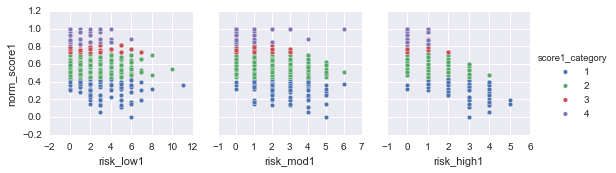

In [103]:
risk1_plot = sns.pairplot(data=df, x_vars = ['risk_low1','risk_mod1','risk_high1'], 
             y_vars = ['norm_score1'], hue='score1_category')

In [104]:
# Determine the SF Health Department scoring system based on number of each level of risk violation vs. score1
model = smf.ols(formula = 'score1 ~ risk_low1 + risk_mod1 + risk_high1', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 score1   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 5.679e+04
Date:                Wed, 24 Aug 2016   Prob (F-statistic):               0.00
Time:                        12:11:55   Log-Likelihood:                -7188.3
No. Observations:                4264   AIC:                         1.438e+04
Df Residuals:                    4260   BIC:                         1.441e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     99.7767      0.031   3188.168      0.000        99.715    99.838
risk_low1     -1.9491      0.014   -138.691      0.000        -1.977    -1.922
risk_mod1     -3.8919      0.020   -191.810      0.000        -3.932    -3.852
risk_high1    -6.9787      0.028   -247.310      0.000        -7.034    -6.923
==============================================================================
Omnibus:                     3242.941   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8234596.914
Skew:                           2.068   Prob(JB):                         0.00
Kurtosis:                     218.247   Cond. No.                         4.03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:
model = smf.ols(formula = 'score2 ~ risk_low2 + risk_mod2 + risk_high2', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 score2   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                 4.436e+04
Date:                Wed, 24 Aug 2016   Prob (F-statistic):               0.00
Time:                        12:11:55   Log-Likelihood:                -7680.7
No. Observations:                4264   AIC:                         1.537e+04
Df Residuals:                    4260   BIC:                         1.539e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     99.6748      0.038   2647.317      0.000        99.601    99.749
risk_low2     -1.9269      0.016   -120.948      0.000        -1.958    -1.896
risk_mod2     -3.9260      0.022   -180.860      0.000        -3.969    -3.883
risk_high2    -6.9243      0.031   -221.693      0.000        -6.986    -6.863
==============================================================================
Omnibus:                     6421.059   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6010512.945
Skew:                          -8.898   Prob(JB):                         0.00
Kurtosis:                     186.067   Cond. No.                         4.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
model.params.round()

Intercept     100.0
risk_low2      -2.0
risk_mod2      -4.0
risk_high2     -7.0
dtype: float64

#### Score formula
score = 100 - 2 x risk_low - 4 x risk_mod - 7 x risk_high

#### Observation
There seem to be some differences between the reported score and the score calculated from the frequency of violation type (Rsquare 0.98-0.97), otherwise the above model would be a perfect fit (Rsquare = 1). The differences will need to be investigated as outliers and determine which score is correct.

In [107]:
def CalcScore1(df):
    model = smf.ols(formula = 'score1 ~ risk_low1 + risk_mod1 + risk_high1', data=df).fit()
    model.params = model.params.round()
    df['score1_calc']=model.params.Intercept + model.params.risk_low1 * df.risk_low1 + \
    model.params.risk_mod1 * df.risk_mod1 + model.params.risk_high1 * df.risk_high1
    
def CalcScore2(df):
    model = smf.ols(formula = 'score2 ~ risk_low2 + risk_mod2 + risk_high2', data=df).fit()
    model.params = model.params.round()
    df['score2_calc']=model.params.Intercept + model.params.risk_low2 * df.risk_low2 + \
    model.params.risk_mod2 * df.risk_mod2 + model.params.risk_high2 * df.risk_high2

In [108]:
dataframe = df.copy()
CalcScore1(dataframe)
CalcScore2(dataframe)

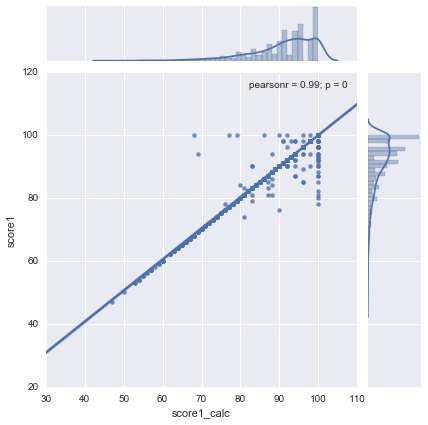

In [109]:
# Score1 outliers
score1calc_score1 = sns.jointplot(x='score1_calc',y='score1',data=dataframe,kind='reg')

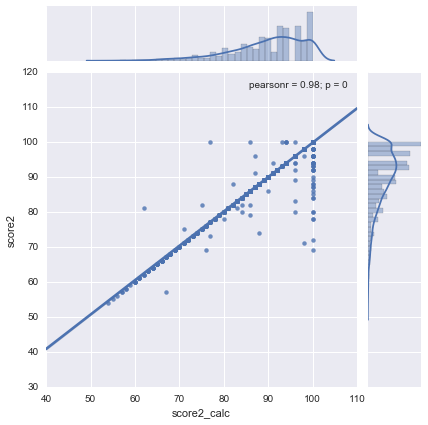

In [110]:
# Score2 outliers
score1calc_score2 = sns.jointplot(x='score2_calc',y='score2',data=dataframe,kind='reg')

In [111]:
score_difference1 = dataframe[abs(dataframe.score1_calc - dataframe.score1)>2]
print('\nscore1:')
print(len(dataframe))
print(len(score_difference1))
print(len(score_difference1)*100./len(dataframe))

score_difference2 = dataframe[abs(dataframe.score2_calc - dataframe.score2)>2]
print('\nscore2:')
print(len(dataframe))
print(len(score_difference2))
print(len(score_difference2)*100./len(dataframe))

score_difference_both = dataframe[(abs(dataframe.score1_calc - dataframe.score1)>2) | 
                                  (abs(dataframe.score2_calc - dataframe.score2)>2)]
print('\nscore both:')
print(len(dataframe))
print(len(score_difference_both))
print(len(score_difference_both)*100./len(dataframe))


score1:
4264
61
1.43058161351

score2:
4264
69
1.6181988743

score both:
4264
125
2.93151969981


#### Observation
Only 125 out of 4264 businesses have scores that do not meet their predicted scores to within 2 points. Since this is only ~3% of the observations, it is easier to justify dropping them then trying to reconcile why the scores may differ.

In [112]:
# Drop rows where the reported scores don't match the calculated scores.
dataframe.drop(score_difference_both.index,inplace=True)
df = dataframe

In [113]:
# Split into train/test dataframes
train = df.sample(frac = .7, random_state = 1)
test = df.drop(train.index)

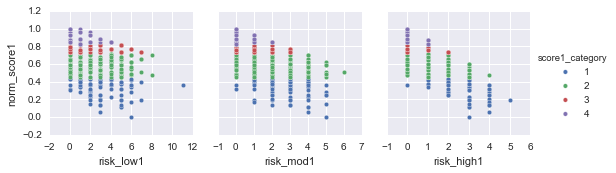

In [126]:
risk1_plot = sns.pairplot(data=train, x_vars = ['risk_low1','risk_mod1','risk_high1'], 
             y_vars = ['norm_score1'], hue='score1_category')

In [114]:
# Re-visit score prediction now with the outliers (see cells above) removed
model = smf.ols(formula = 'score1 ~ risk_low1 + risk_mod1 + risk_high1', data=train).fit()
print('Rsquareds for score1_calc and score2_calc:')
print(model.rsquared.round(2))
model = smf.ols(formula = 'score2 ~ risk_low2 + risk_mod2 + risk_high2', data=train).fit()
print(model.rsquared.round(2))

Rsquareds for score1_calc and score2_calc:
1.0
1.0


#### Observation
As expected, the predicted scores now match the reported scores.

## Exploratory Data Analysis

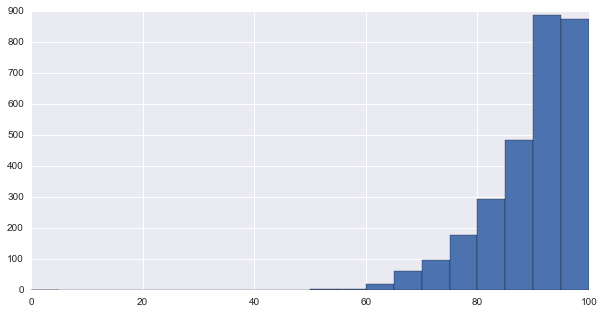

In [115]:
hist_score = train[score].hist(bins=np.arange(0,105,5),figsize=(10,5))

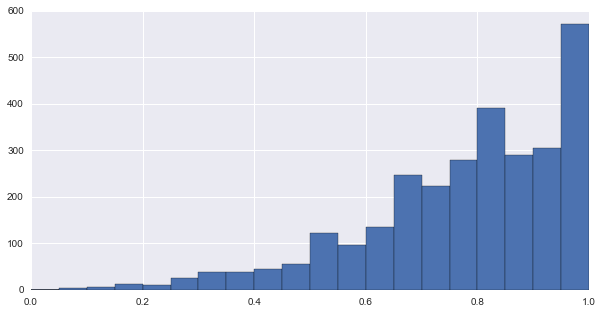

In [116]:
hist_norm_score = train['norm_'+score].hist(bins=np.arange(0,1.05,.05),figsize=(10,5))

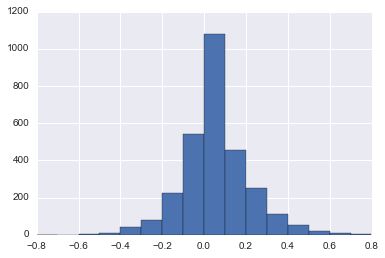

In [117]:
hist_diff = (train.norm_score1-train.norm_score2).hist(bins=np.arange(-.8,.9,.1))

#### Observation
The difference between score1 and score2 appears to be normally distributed.

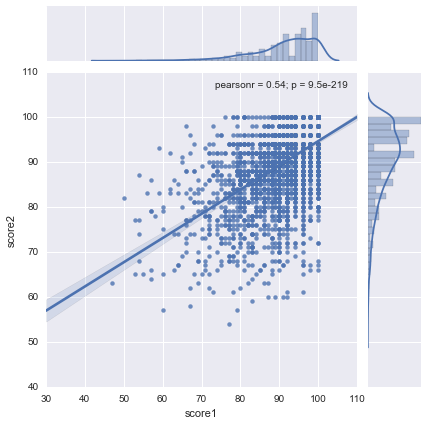

In [118]:
score_score = sns.jointplot(x='score1',y='score2',data=train,kind='reg')

In [119]:
model = smf.ols(formula = 'score2 ~ score1', data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 score2   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     1190.
Date:                Wed, 24 Aug 2016   Prob (F-statistic):          9.47e-219
Time:                        12:11:57   Log-Likelihood:                -9762.9
No. Observations:                2897   AIC:                         1.953e+04
Df Residuals:                    2895   BIC:                         1.954e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     40.7787      1.426     28.589      0.000        37.982    43.576
score1         0.5378      0.016     34.496      0.000         0.507     0.568
==============================================================================
Omnibus:                      428.483   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              746.631
Skew:                          -0.959   Prob(JB):                    7.43e-163
Kurtosis:                       4.584   Cond. No.                         998.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

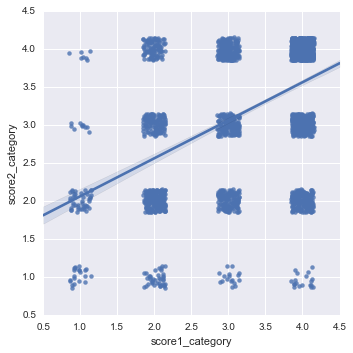

In [120]:
cat_cat = sns.lmplot(x='score1_category', y='score2_category', data=train, x_jitter=.15, y_jitter=.15)

In [121]:
model = smf.ols(formula = 'score2_category ~ score1_category', data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        score2_category   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     863.1
Date:                Wed, 24 Aug 2016   Prob (F-statistic):          2.87e-166
Time:                        12:11:58   Log-Likelihood:                -3453.8
No. Observations:                2897   AIC:                             6912.
Df Residuals:                    2895   BIC:                             6923.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           1.5599      0.060     26.215      0.000         1.443     1.677
score1_category     0.5001      0.017     29.379      0.000         0.467     0.533
==============================================================================
Omnibus:                      201.619   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              245.099
Skew:                          -0.712   Prob(JB):                     5.99e-54
Kurtosis:                       3.073   Cond. No.                         15.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

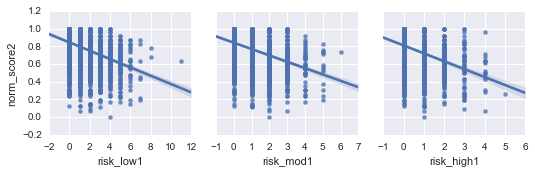

In [122]:
risk_predict_plot = sns.pairplot(data=train, x_vars = ['risk_low1','risk_mod1','risk_high1'], 
             y_vars = ['norm_score2'], kind = 'reg')

In [123]:
model = smf.ols(formula = 'score2 ~ risk_low1 + risk_mod1 + risk_high1', data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 score2   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     422.0
Date:                Wed, 24 Aug 2016   Prob (F-statistic):          2.14e-227
Time:                        12:11:59   Log-Likelihood:                -9735.9
No. Observations:                2897   AIC:                         1.948e+04
Df Residuals:                    2893   BIC:                         1.950e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     95.0708      0.202    470.719      0.000        94.675    95.467
risk_low1     -1.5885      0.092    -17.319      0.000        -1.768    -1.409
risk_mod1     -2.2881      0.134    -17.042      0.000        -2.551    -2.025
risk_high1    -2.8603      0.185    -15.425      0.000        -3.224    -2.497
==============================================================================
Omnibus:                      445.061   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              792.379
Skew:                          -0.981   Prob(JB):                    8.65e-173
Kurtosis:                       4.647   Cond. No.                         4.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

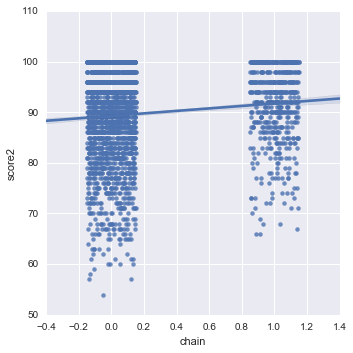

In [124]:
chain_plot2 = sns.lmplot(x='chain', y='score2', data=train, x_jitter=.15)

In [125]:
model = smf.ols(formula = 'score2 ~ chain', data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 score2   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     40.59
Date:                Wed, 24 Aug 2016   Prob (F-statistic):           2.18e-10
Time:                        12:11:59   Log-Likelihood:                -10242.
No. Observations:                2897   AIC:                         2.049e+04
Df Residuals:                    2895   BIC:                         2.050e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     89.2793      0.173    516.682      0.000        88.941    89.618
chain          2.4434      0.384      6.371      0.000         1.691     3.195
==============================================================================
Omnibus:                      384.291   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              555.391
Skew:                          -0.994   Prob(JB):                    2.50e-121
Kurtosis:                       3.807   Cond. No.                         2.61
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""